# Step 15: Interpreting feedforward networks

In order to better understand where the predictions come from, we want to do the following things:
1. Examine feature and label relationships using rank correlation.
2. Train comparable random forest
3. Calculate feature importance
4. Create partial dependence plots
5. Use lime package to explain single predicitons

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from tep.utils import load_array
feats = load_array('data/auxiliary_features.bc')
feats.shape

(1293005, 15)

In [3]:
import numpy as np

In [4]:
labels = load_array('data/regression_labels.bc')
labels = np.log1p(labels)
labels.shape

(1293005,)

In [5]:
data = np.column_stack(tup=(feats, labels))
data.shape

(1293005, 16)

In [6]:
from tep.modelUtils import load_architecture
model = load_architecture('models/dffn_reg_5h_64n.json')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalized_inputs (BatchNorm (None, 15)                60        
_________________________________________________________________
fc_1 (Dense)                 (None, 64)                1024      
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 64)                256       
_________________________________________________________________
fc_2 (Dense)                 (None, 64)                4160      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 64)                256       
_________________________________________________________________
fc_3 (Dense)                 (None, 64)                4160      
_________________________________________________________________
bn_3 (BatchNormalization)    (None, 64)                256       
__________

In [7]:
model.load_weights('models/dffn_reg_5h_64n.hdf5')

In [8]:
preds = model.predict(feats[-10000:])
acts = labels[-10000:]

In [9]:
from tep.trainUtils import r2
from keras.optimizers import Adam
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=[r2])

In [10]:
model.evaluate(x=feats[-10000:], y=labels[-10000:])

10000/10000 [==============================] - 1s 107us/step


[1.0348384994506836, 0.74490957508087163]

In [11]:
import pandas as pd
columns = ['urls', 'hashtags', 'mentions', 'length', 'followers', 'friends', 'verified', 'listings', 'tweets', 'tweet_freq', 'favorites', 'favorite_freq', 'account_age', 'hour', 'quote', 'retweets']
df = pd.DataFrame(data=data, columns=columns)

In [12]:
df.head()

,urls,hashtags,mentions,length,followers,friends,verified,listings,tweets,tweet_freq,favorites,favorite_freq,account_age,hour,quote,retweets
0,0.0,0.0,0.0,78.0,1282170.0,4029.0,1.0,3132.0,13623.0,4.049643,4134.0,1.228894,3364.0,20.0,0.0,4.795791
1,1.0,0.0,0.0,139.0,2567.0,2931.0,0.0,46.0,2318.0,1.115496,201.0,0.096728,2078.0,16.0,0.0,0.000000
2,1.0,2.0,0.0,89.0,14580.0,2447.0,1.0,380.0,7333.0,2.220775,1385.0,0.419443,3302.0,14.0,0.0,1.386294
3,1.0,0.0,0.0,123.0,415819.0,50.0,1.0,2382.0,5775.0,2.970679,250.0,0.128601,1944.0,19.0,0.0,1.791759
4,1.0,0.0,2.0,135.0,21285.0,2568.0,1.0,435.0,12513.0,4.457784,9239.0,3.291414,2807.0,19.0,0.0,0.000000


## Feature and label rank correlation

We calculate rank correlation because we don't necessarily expect linear relationships in our data. Also, rank correlation is a nonparametric measure, i.e., we do not assume that the dataset is normally distributed.

In [13]:
from scipy.stats import spearmanr

In [14]:
corr = np.round(spearmanr(df).correlation, 4)

In [15]:
corr.shape

(16, 16)

In [16]:
import matplotlib.pyplot as plt

def plot_corr(corr, columns):
    fig = plt.figure(figsize=(20,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(columns),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(columns)
    ax.set_yticklabels(columns)
    plt.show()
    return

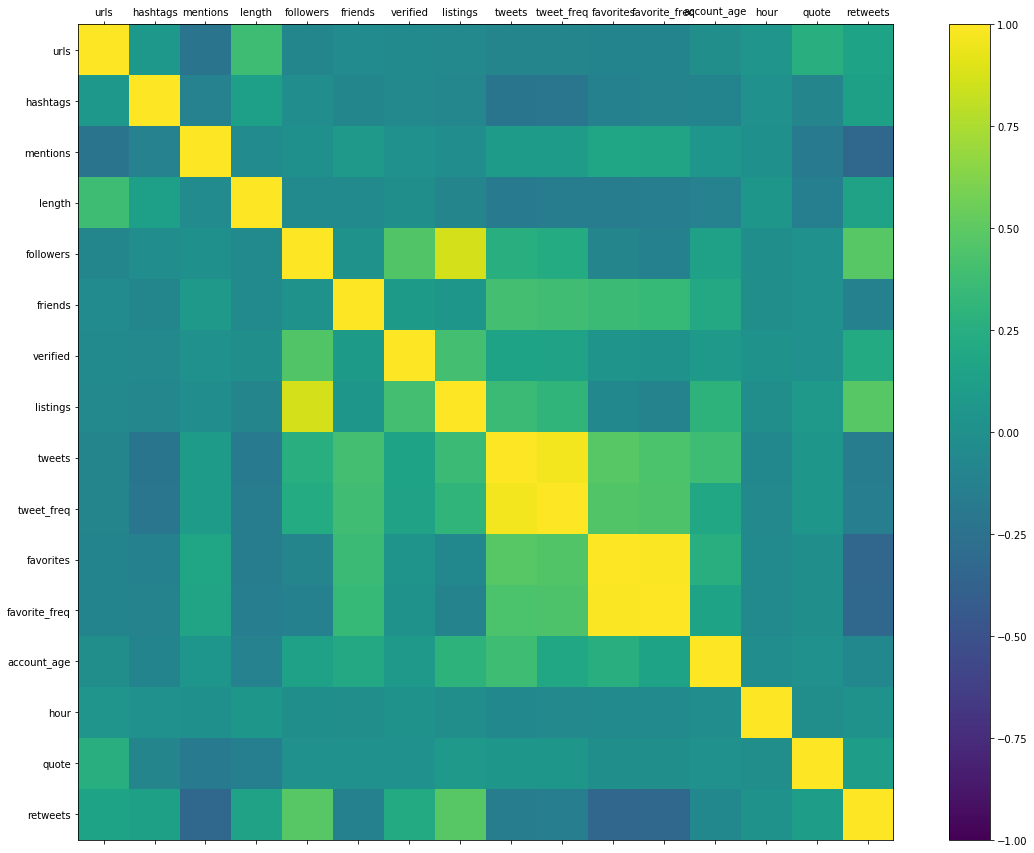

In [17]:
plot_corr(corr, columns)

Unsurprisingly, this suggests that the number of followers and listings are the strongest indicators of a tweet's engagement. We can also see that content features alone are not useful for predicting retweets, as correlation is weak here.

## Train comparable random forest

In [20]:
X_train = feats[:-10000]
y_train = labels[:-10000]
X_valid = feats[-10000:]
y_valid = labels[-10000:]
print(X_train.shape)
print(y_valid.shape)

(1283005, 15)
(10000,)


In [24]:
import math
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.5357471027770475, 0.9858492788843487, 0.93728668860306796, 0.78961926489285028, 0.78039921990144123]


In [28]:
m1 = RandomForestRegressor(n_estimators=160, n_jobs=-1, oob_score=True)
m1.fit(X_train, y_train)
print_score(m1)

[0.5287627085594702, 0.9767416700486157, 0.93891118399397955, 0.79348844622250747, 0.78715162465302457]


In [29]:
m2 = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=2, oob_score=True)
m2.fit(X_train, y_train)
print_score(m2)

[0.6471390483845024, 0.9455552132909321, 0.90849701059883392, 0.80646536000335922, 0.79787672875530036]


In [30]:
m2 = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, oob_score=True)
m2.fit(X_train, y_train)
print_score(m2)

[0.7070312805956193, 0.9307941547125923, 0.89077618855452978, 0.81246073194486201, 0.80489101186733802]


In [31]:
m3 = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=4, oob_score=True)
m3.fit(X_train, y_train)
print_score(m3)

[0.7432824281115998, 0.9196585028326915, 0.87928873465877377, 0.81692118061749042, 0.80861377889065977]


In [34]:
m4 = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=5, oob_score=True)
m4.fit(X_train, y_train)
print_score(m4)

[0.7678710263496354, 0.9121146043647508, 0.87117011100082931, 0.81991242871544767, 0.81104797079964874]


In [35]:
m5 = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=6, oob_score=True)
m5.fit(X_train, y_train)
print_score(m5)

[0.7859137096152443, 0.9105620251397684, 0.86504474495562811, 0.8205249882692125, 0.81242391640840428]


In [36]:
m6 = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=8, oob_score=True)
m6.fit(X_train, y_train)
print_score(m6)

[0.8108174455968912, 0.908279284005237, 0.85635641364249371, 0.82142373308054162, 0.81412450006273462]
